### Question 1

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [8]:
# implementing these functions from the "utils.py" file

def create_mlp_model(n_hidden_layers, dim_layer, input_shape, n_classes,
                     kernel_initializer, bias_initializer, activation):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation,
                        kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model

def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model

def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """Yield subplot axes on a grid."""
    from matplotlib import rcParamsDefault
    n_rows = n_plots // n_cols + int(n_plots % n_cols > 0)
    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(default_figsize[0] * n_cols, default_figsize[1] * n_rows))
    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax

In [13]:
def extract_gradients(model, hidden_layers, x, y_true):
    # converting to tensors
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

    # storing operations for gradient computation
    with tf.GradientTape() as tape:
        # store activations at hidden layers
        activations = []
        z = x
        for i, layer in enumerate(model.layers[:-1]):
            z = layer(z)
            activations.append(z)
        y_pred = model.layers[-1](z)
        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))

    gradients = tape.gradient(loss, activations)
    return gradients


In [15]:
# loading and preprocessing dataset
seed = 10
sns.set_style('white')
sns.set_palette('colorblind')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
x_test = x_test[:100]  # reduce size for faster evaluation

n_classes = 10
data_dim = 784
n_hidden_layers = 5
dim_layer = 100
sigmas = [0.10, 0.14, 0.28]
activations = ['sigmoid', 'tanh']

dummy_labels = np.ones((x_test.shape[0], n_classes)) / n_classes  # uniform softmax targets


In [22]:
results = []

for activation in activations:
    for stddev in sigmas:
        print(f"Testing: activation={activation}, stddev={stddev}")
        weight_initializer = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)

        model = create_mlp_model(n_hidden_layers, dim_layer, (data_dim,), n_classes,
                                 kernel_initializer=weight_initializer,
                                 bias_initializer='zeros',
                                 activation=activation)
        compile_model(model)

        intermediate_outputs = [layer.output for layer in model.layers[:-1]]  # exclude final softmax layer
        grads = extract_gradients(model, intermediate_outputs, x_test, dummy_labels)

        for layer_num, gradients in enumerate(grads):
            sampled_vals = tf.reshape(gradients, [-1]).numpy()[::20]
            for grad_entry in sampled_vals:
                results.append({
                    'Activation': activation,
                    'StdDev': stddev,
                    'Layer': layer_num + 1,
                    'Gradient': grad_entry
                })

Testing: activation=sigmoid, stddev=0.1
Testing: activation=sigmoid, stddev=0.14


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: activation=sigmoid, stddev=0.28
Testing: activation=tanh, stddev=0.1
Testing: activation=tanh, stddev=0.14
Testing: activation=tanh, stddev=0.28


<ipython-input-23-c30e4d2c29e1>:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, ax=ax, scale='width', inner=None)
<ipython-input-23-c30e4d2c29e1>:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, ax=ax, scale='width', inner=None)
<ipython-input-23-c30e4d2c29e1>:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, ax=ax, scale='width', inner=None)


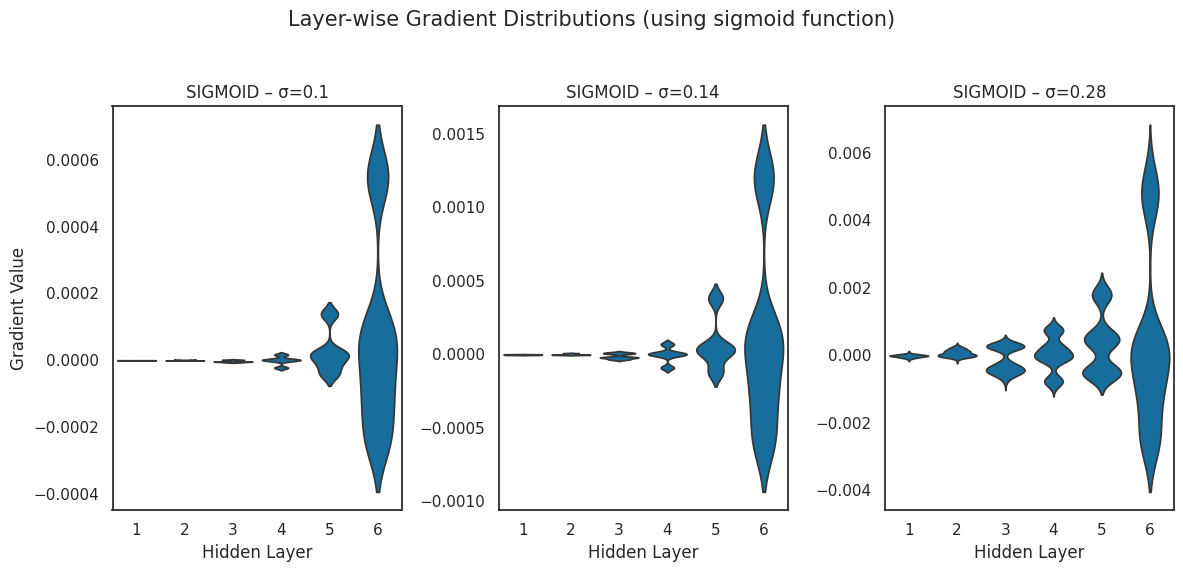

<ipython-input-23-c30e4d2c29e1>:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, ax=ax, scale='width', inner=None)
<ipython-input-23-c30e4d2c29e1>:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, ax=ax, scale='width', inner=None)
<ipython-input-23-c30e4d2c29e1>:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, ax=ax, scale='width', inner=None)


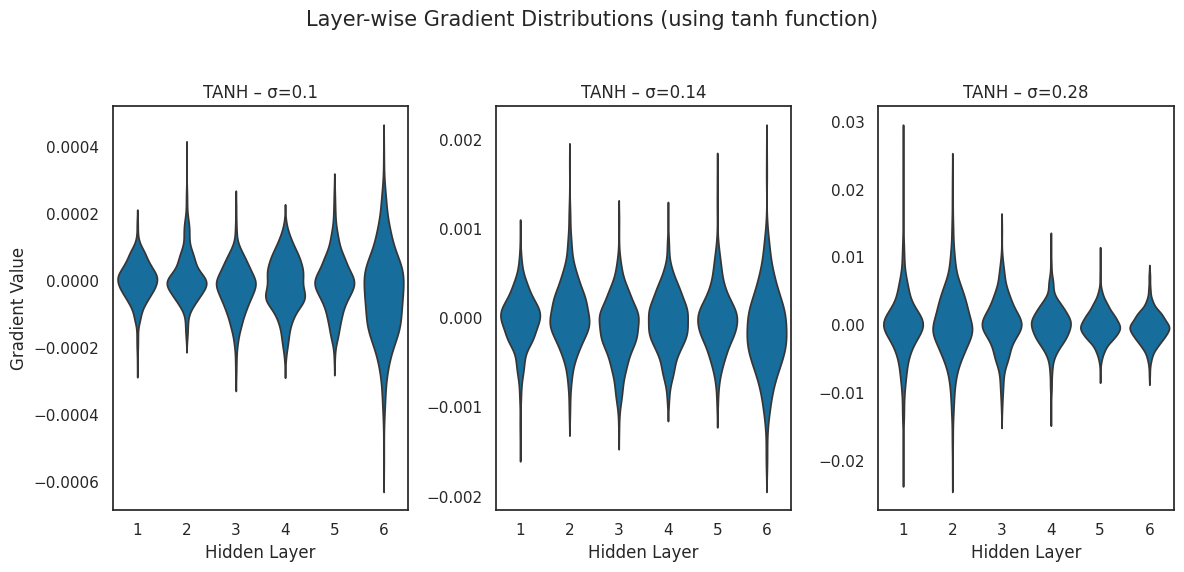

In [23]:
df = pd.DataFrame(results)

# plotting gradient distributions for each activation and stddev combination
for activation in activations:
    plt.figure(figsize=(12, 6))
    for i, stddev in enumerate(sigmas):
        ax = plt.subplot(1, 3, i + 1)
        ddf = df[(df['Activation'] == activation) & (df['StdDev'] == stddev)]
        sns.violinplot(x='Layer', y='Gradient', data=ddf, ax=ax, scale='width', inner=None)
        ax.set_title(f"{activation.upper()} – σ={stddev}")
        ax.set_xlabel("Hidden Layer")
        if i == 0:
            ax.set_ylabel("Gradient Value")
        else:
            ax.set_ylabel("")
    plt.suptitle(f"Layer-wise Gradient Distributions (using {activation} function)", fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


From the visualizations, I observed a clear difference in gradient behavior depending on both the activation function and the initialization standard deviation ($\sigma$).

For sigmoid activation, when $\sigma$ = 0.1, most gradients are extremely small, especially in the earlier layers, indicating a vanishing gradient problem. This suggests that the signal diminishes as it propagates backward, making it difficult for early layers to learn. Increasing $\sigma$ to 0.14 and 0.28 results in larger gradient magnitudes, particularly in deeper layers. However, this increase can introduce instability or exploding gradients if not controlled, which is indicated by the wider distribution in later layers.


On the other hand, the tanh activation function produces generally larger and more consistent gradient magnitudes across layers compared to sigmoid activation, especially when $\sigma$ = 0.1. As $\sigma$ increases to 0.14 and 0.28, the gradients remain better distributed across layers, although there's still some decrease in earlier layers. Overall, the tanh function seems to preserve gradient flow better than sigmoid, most likely due to its zero-centered output.

Therefore, we can conclude that smaller $\sigma$ values lead to vanishing gradients, particularly for the sigmoid function. The tanh function is less susceptible to vanishing gradients than sigmoid, especially in deeper networks.
Thus, choosing the right combination of activation function and weight initialization is critical for maintaining effective gradient flow and training deep neural networks efficiently.

### Question 2

In [24]:
from keras.initializers import glorot_normal

# setup for Glorot initialization

glorot_results = []

for activation in ['sigmoid', 'tanh']:
    print(f"Testing Xavier/Glorot for: {activation} function")
    glorot_init = glorot_normal(seed=10)

    glorot_model = create_mlp_model(n_hidden_layers, dim_layer, (data_dim,), n_classes,
                             kernel_initializer=glorot_init,
                             bias_initializer='zeros',
                             activation=activation)
    compile_model(glorot_model)

    grad_vals = extract_gradients(glorot_model, glorot_model.layers, x_test, dummy_labels)

    for layer_num, gradients in enumerate(grad_vals):
        sampled_vals = gradients.numpy().reshape(-1)[::20]
        for grad_entry in sampled_vals:
            glorot_results.append({
                'Activation': activation,
                'Layer': layer_num + 1,
                'Gradient': grad_entry
            })


Testing Xavier/Glorot for: sigmoid function
Testing Xavier/Glorot for: tanh function


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<ipython-input-26-ceb27c65ec95>:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, scale='width', inner=None)


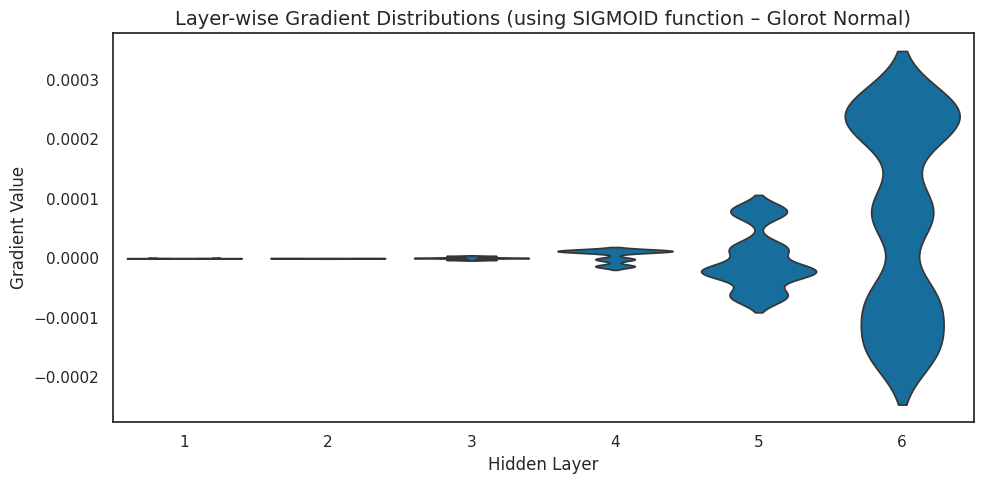

<ipython-input-26-ceb27c65ec95>:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Layer', y='Gradient', data=ddf, scale='width', inner=None)


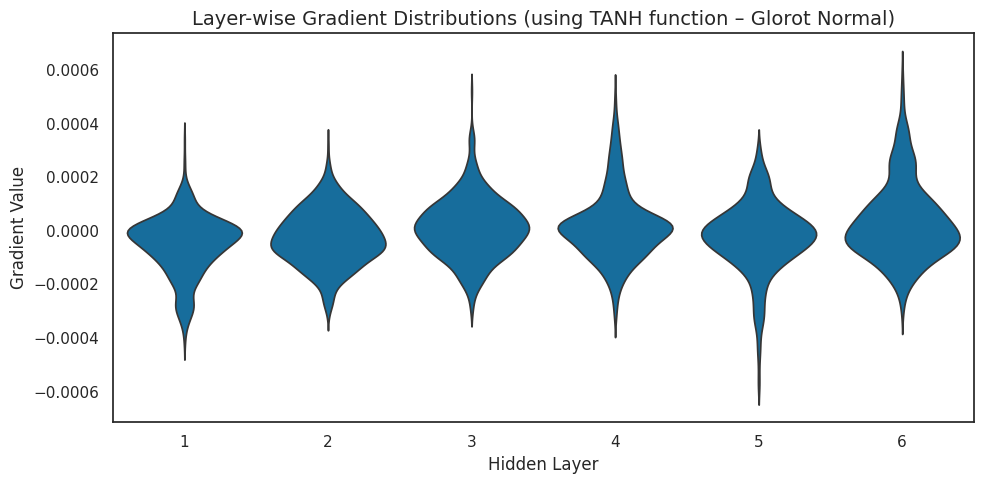

In [26]:
# plotting results for glorot initialization
df_glorot = pd.DataFrame(glorot_results)

for activation in ['sigmoid', 'tanh']:
    plt.figure(figsize=(10, 5))
    ddf = df_glorot[df_glorot['Activation'] == activation]
    sns.violinplot(x='Layer', y='Gradient', data=ddf, scale='width', inner=None)
    plt.title(f"Layer-wise Gradient Distributions (using {activation.upper()} function – Glorot Normal)", fontsize=14)
    plt.xlabel("Hidden Layer")
    plt.ylabel("Gradient Value")
    plt.tight_layout()
    plt.show()

When comparing the plots generated using Glorot Normal initialization to previous plots, which used Random Normal initialization, I noticed significant improvements in the stability and distribution of gradient values, especially in deeper layers.

With Random Normal initialization, gradients for the sigmoid activation function were extremely small in early layers and were very susceptible to the vanishing gradient problem. With Glorot initialization, the gradient magnitudes for the sigmoid function are still small in early layers, but become much larger in deeper layers, especially for Layers 5 and 6. Although some decay still occurs, the gradients persist deeper into the network, reducing the vanishing gradient effect significantly when using Glorot initialization compared to Random Normal initialization for the sigmoid function.


In the previous plots, the tanh function already performed better than sigmoid under Random Normal initialization, showing more stable gradient flow. But with Glorot initialization, tanh gradients become even more uniformly distributed, without any indication of sharp decay or exploding gradients. The gradient values are more balanced across all layers, and the drop-off seen in deeper layers is far less pronounced than before, which suggests that Glorot initialization is very suitable for using in combination with the tanh function.

In conclusion, Glorot Normal initialization improves gradient flow across layers for both sigmoid and tanh activations. It addresses vanishing gradients more effectively than simple Random Normal initialization by scaling the weights in a way that preserves the variance of activations and gradients across layers. This results in deeper networks being more trainable and stable, which highlights the importance of proper weight initialization in deep learning models.

### Question 3

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
import numpy as np
import gc

# setting seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# using f1(x) = |x| from the Lu et al. paper
def target_function(x):
    return np.abs(x)

# setting parameters
n_simulations = 1000
n_points = 3000
batch_size = 64
width = 2
depth = 10
input_dim = 1
threshold = 1e-4  # setting this as the collapse threshold to capture "dying relu" networks

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
# model builder with Kaiming initialization
def model_builder():
    layers = []
    for i in range(depth):
        in_dim = input_dim if i == 0 else width
        linear = nn.Linear(in_dim, width)
        nn.init.kaiming_uniform_(linear.weight, nonlinearity='relu')
        nn.init.zeros_(linear.bias)
        layers.extend([linear, nn.ReLU()])
    layers.append(nn.Linear(width, 1))  # final layer
    return nn.Sequential(*layers).to(device)

In [38]:
# running simulations
collapsed_networks = 0
n_batches = n_simulations // batch_size

for b in range(n_batches):
    print(f"\nRunning Batch {b + 1} of {n_batches}")
    for _ in trange(batch_size):
        # generating synthetic data
        x_np = np.random.uniform(-np.sqrt(7), np.sqrt(7), size=(n_points, 1)).astype(np.float32)
        y_np = target_function(x_np)

        x_tensor = torch.tensor(x_np, device=device)
        y_tensor = torch.tensor(y_np, device=device)

        # initialize and train model
        model = model_builder()
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        model.train()
        for _ in range(1):  # one epoch
            optimizer.zero_grad()
            output = model(x_tensor)
            loss = loss_fn(output, y_tensor)
            loss.backward()
            optimizer.step()

        # evaluate collapse
        model.eval()
        with torch.no_grad():
            y_pred = model(x_tensor).cpu().numpy()
            if np.var(y_pred) < threshold:
                collapsed_networks += 1

        # freeing up memory
        del model, x_tensor, y_tensor, y_pred, loss, output
        torch.cuda.empty_cache()
        gc.collect()


Running Batch 1 of 15


100%|██████████| 64/64 [00:31<00:00,  2.05it/s]



Running Batch 2 of 15


100%|██████████| 64/64 [00:28<00:00,  2.23it/s]



Running Batch 3 of 15


100%|██████████| 64/64 [00:27<00:00,  2.33it/s]



Running Batch 4 of 15


100%|██████████| 64/64 [00:29<00:00,  2.19it/s]



Running Batch 5 of 15


100%|██████████| 64/64 [00:28<00:00,  2.23it/s]



Running Batch 6 of 15


100%|██████████| 64/64 [00:28<00:00,  2.22it/s]



Running Batch 7 of 15


100%|██████████| 64/64 [00:26<00:00,  2.40it/s]



Running Batch 8 of 15


100%|██████████| 64/64 [00:26<00:00,  2.38it/s]



Running Batch 9 of 15


100%|██████████| 64/64 [00:27<00:00,  2.36it/s]



Running Batch 10 of 15


100%|██████████| 64/64 [00:27<00:00,  2.31it/s]



Running Batch 11 of 15


100%|██████████| 64/64 [00:27<00:00,  2.29it/s]



Running Batch 12 of 15


100%|██████████| 64/64 [00:27<00:00,  2.32it/s]



Running Batch 13 of 15


100%|██████████| 64/64 [00:26<00:00,  2.38it/s]



Running Batch 14 of 15


100%|██████████| 64/64 [00:27<00:00,  2.36it/s]



Running Batch 15 of 15


100%|██████████| 64/64 [00:27<00:00,  2.37it/s]


In [39]:
# final report
collapse_rate = 100 * collapsed_networks / n_simulations
print(f"\nNumber of collapsed networks: {collapsed_networks}")
print(f"\nFraction of collapsed networks: {collapse_rate:.2f}%")


Number of collapsed networks: 903

Fraction of collapsed networks: 90.30%


To demonstrate the dying ReLU phenomenon, I implemented a 10-layer ReLU network with 2 units per hidden layer, and conducted 1,000 simulations using a minibatch size of 64 and trained on 3,000 points generated from the function $f(x) = |x|$, which I chose from Lu et al.'s paper. I set a threshold of 1e-4, meaning that a network was considered "collapsed" if the variance of its output predictions was less than a small threshold of $10^{-4}$, indicating the network had lost its ability to distinguish between inputs.

Out of the 1,000 simulations, 903 networks collapsed, resulting in a collapse rate of 90.30%. This matches the ~90% collapse rate reported in Lu et al.'s paper and highlights the severe instability of deep ReLU networks, especially when not carefully initialized or regularized. These results confirm that the dying ReLU issue commonly arises in deep and narrow ReLU networks.

### Question 4

In [40]:
# re-building model with leaky relu instead
def leaky_model_builder():
    layers = []
    for i in range(depth):
        in_dim = input_dim if i == 0 else width
        linear = nn.Linear(in_dim, width)
        nn.init.kaiming_uniform_(linear.weight, nonlinearity='leaky_relu')
        nn.init.zeros_(linear.bias)
        layers += [linear, nn.LeakyReLU(negative_slope=0.01)]
    layers.append(nn.Linear(width, 1))
    return nn.Sequential(*layers).to(device)


In [41]:
# repeating the same code as above, but using the Leaky ReLU model

# running simulations
collapsed_networks = 0
n_batches = n_simulations // batch_size

for b in range(n_batches):
    print(f"\nRunning Batch {b + 1} of {n_batches}")
    for _ in trange(batch_size):
        # generating synthetic data
        x_np = np.random.uniform(-np.sqrt(7), np.sqrt(7), size=(n_points, 1)).astype(np.float32)
        y_np = target_function(x_np)

        x_tensor = torch.tensor(x_np, device=device)
        y_tensor = torch.tensor(y_np, device=device)

        # initialize and train model
        model = model_builder()
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        model.train()
        for _ in range(1):  # one epoch
            optimizer.zero_grad()
            output = model(x_tensor)
            loss = loss_fn(output, y_tensor)
            loss.backward()
            optimizer.step()

        # evaluate collapse
        model.eval()
        with torch.no_grad():
            y_pred = model(x_tensor).cpu().numpy()
            if np.var(y_pred) < threshold:
                collapsed_networks += 1

        # freeing up memory
        del model, x_tensor, y_tensor, y_pred, loss, output
        torch.cuda.empty_cache()
        gc.collect()


Running Batch 1 of 15


100%|██████████| 64/64 [00:27<00:00,  2.35it/s]



Running Batch 2 of 15


100%|██████████| 64/64 [00:27<00:00,  2.35it/s]



Running Batch 3 of 15


100%|██████████| 64/64 [00:27<00:00,  2.35it/s]



Running Batch 4 of 15


100%|██████████| 64/64 [00:27<00:00,  2.36it/s]



Running Batch 5 of 15


100%|██████████| 64/64 [00:27<00:00,  2.37it/s]



Running Batch 6 of 15


100%|██████████| 64/64 [00:27<00:00,  2.34it/s]



Running Batch 7 of 15


100%|██████████| 64/64 [00:27<00:00,  2.35it/s]



Running Batch 8 of 15


100%|██████████| 64/64 [00:27<00:00,  2.37it/s]



Running Batch 9 of 15


100%|██████████| 64/64 [00:26<00:00,  2.38it/s]



Running Batch 10 of 15


100%|██████████| 64/64 [00:27<00:00,  2.36it/s]



Running Batch 11 of 15


100%|██████████| 64/64 [00:27<00:00,  2.36it/s]



Running Batch 12 of 15


100%|██████████| 64/64 [00:27<00:00,  2.32it/s]



Running Batch 13 of 15


100%|██████████| 64/64 [00:28<00:00,  2.28it/s]



Running Batch 14 of 15


100%|██████████| 64/64 [00:26<00:00,  2.39it/s]



Running Batch 15 of 15


100%|██████████| 64/64 [00:26<00:00,  2.37it/s]


In [42]:
# final report
collapse_rate = 100 * collapsed_networks / n_simulations
print(f"\nNumber of collapsed networks: {collapsed_networks}")
print(f"\nFraction of collapsed networks: {collapse_rate:.2f}%")


Number of collapsed networks: 896

Fraction of collapsed networks: 89.60%


To mitigate the dying ReLU problem, I repeated the experiment using Leaky ReLU, where the activation function allows a small non-zero gradient (slope = 0.01) when the input is negative. All other settings remained the same, as per the instructions (depth = 10, width = 2, 1,000 simulations, batch size = 64).

This time, 896 out of 1,000 networks collapsed, yielding a collapse rate of 89.60%. While this is only a slight improvement over ReLU, it demonstrates that Leaky ReLU reduces, but does not completely eliminate, the dying neuron problem. By allowing small gradients even for negative inputs, Leaky ReLU ensures that neurons can recover and remain trainable more often than with standard ReLU.

This result suggests that Leaky ReLU doesn't significantly reduce collapse under these specific conditions. Even though Leaky ReLU allows small gradients for negative inputs (unlike standard ReLU), very deep and narrow networks (like depth = 10, width = 2) are still highly prone to collapse if not properly initialized or regularized. This highlights how sensitive such architectures are to design choices, and shows that Leaky ReLU alone isn't enough to fix the problem.